## 1. Import Libraries

In [1]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import(
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
    MinMaxScaler,
    PowerTransformer,
    FunctionTransformer
)
from feature_engine.outliers import Winsorizer
from feature_engine.selection import SelectBySingleFeaturePerformance
from feature_engine.encoding import (
    RareLabelEncoder,
    MeanEncoder,
    CountFrequencyEncoder
)
from feature_engine.datetime import DatetimeFeatures

import warnings
warnings.filterwarnings("ignore")

## 2. Display Settings

In [2]:
pd.set_option("display.max_columns",None)

In [3]:
sklearn.set_config(transform_output="pandas")

## 3. Read the Data

In [4]:
path = r"C:\Users\CHAMLIN\Desktop\flights-sagemaker-project\data\train.csv"
train = pd.read_csv(path)
train

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
0,Air India,2019-05-27,Delhi,Cochin,09:45:00,23:00:00,795,1.0,No Info,8907
1,Indigo,2019-05-24,Kolkata,Banglore,20:20:00,22:55:00,155,0.0,No Info,4804
2,Jet Airways,2019-06-01,Delhi,Cochin,11:30:00,12:35:00,1505,1.0,In-flight meal not included,10262
3,Air India,2019-06-03,Delhi,Cochin,13:15:00,09:25:00,1210,2.0,No Info,10467
4,Jet Airways,2019-03-12,Banglore,New Delhi,18:55:00,10:45:00,950,1.0,In-flight meal not included,11087
...,...,...,...,...,...,...,...,...,...,...
635,Air India,2019-06-06,Kolkata,Banglore,09:25:00,18:30:00,545,1.0,No Info,8366
636,Air India,2019-05-15,Delhi,Cochin,13:20:00,07:40:00,1100,2.0,No Info,13538
637,Air India,2019-03-12,Banglore,New Delhi,06:45:00,09:25:00,1600,2.0,No Info,12515
638,Jet Airways,2019-06-01,Delhi,Cochin,06:45:00,04:25:00,1300,2.0,In-flight meal not included,10919


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 640 entries, 0 to 639
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   airline          640 non-null    object 
 1   date_of_journey  640 non-null    object 
 2   source           640 non-null    object 
 3   destination      640 non-null    object 
 4   dep_time         640 non-null    object 
 5   arrival_time     640 non-null    object 
 6   duration         640 non-null    int64  
 7   total_stops      639 non-null    float64
 8   additional_info  640 non-null    object 
 9   price            640 non-null    int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 50.1+ KB


In [6]:
X_train = train.drop(columns="price")
y_train = train.price.copy()

## 4. Transformation Operations

In [7]:
X_train.columns.to_list()

['airline',
 'date_of_journey',
 'source',
 'destination',
 'dep_time',
 'arrival_time',
 'duration',
 'total_stops',
 'additional_info']

### 4.1 airline

In [8]:
X_train.airline

0        Air India
1           Indigo
2      Jet Airways
3        Air India
4      Jet Airways
          ...     
635      Air India
636      Air India
637      Air India
638    Jet Airways
639        Vistara
Name: airline, Length: 640, dtype: object

In [9]:
air_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("grouper", RareLabelEncoder(tol=0.1, replace_with="Other", n_categories=2)),
    ("encoder", OneHotEncoder(sparse_output=False, handle_unknown="ignore"))
])

air_transformer.fit_transform(X_train.loc[:, ["airline"]])

,airline_Air India,airline_Indigo,airline_Jet Airways,airline_Multiple Carriers,airline_Other
0,1.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...
635,1.0,0.0,0.0,0.0,0.0
636,1.0,0.0,0.0,0.0,0.0
637,1.0,0.0,0.0,0.0,0.0
638,0.0,0.0,1.0,0.0,0.0


### 4.2 date_of_journey

In [10]:
X_train.date_of_journey

0      2019-05-27
1      2019-05-24
2      2019-06-01
3      2019-06-03
4      2019-03-12
          ...    
635    2019-06-06
636    2019-05-15
637    2019-03-12
638    2019-06-01
639    2019-05-27
Name: date_of_journey, Length: 640, dtype: object

In [11]:
feature_to_extract =["month","week","day_of_week","day_of_year"]

doj_transformer = Pipeline(steps=[
    ("dt", DatetimeFeatures(features_to_extract=feature_to_extract, yearfirst=True)),
    ("scaler", MinMaxScaler())
])

doj_transformer.fit_transform(X_train.loc[:, ["date_of_journey"]])

,date_of_journey_month,date_of_journey_week,date_of_journey_day_of_week,date_of_journey_day_of_year
0,0.666667,0.764706,0.000000,0.737288
1,0.666667,0.705882,0.666667,0.711864
2,1.000000,0.764706,0.833333,0.779661
3,1.000000,0.823529,0.000000,0.796610
4,0.000000,0.117647,0.166667,0.093220
...,...,...,...,...
635,1.000000,0.823529,0.500000,0.822034
636,0.666667,0.647059,0.333333,0.635593
637,0.000000,0.117647,0.166667,0.093220
638,1.000000,0.764706,0.833333,0.779661


### 4.3 source & destination

In [12]:
X_train.source

0         Delhi
1       Kolkata
2         Delhi
3         Delhi
4      Banglore
         ...   
635     Kolkata
636       Delhi
637    Banglore
638       Delhi
639    Banglore
Name: source, Length: 640, dtype: object

In [13]:
X_train.destination

0         Cochin
1       Banglore
2         Cochin
3         Cochin
4      New Delhi
         ...    
635     Banglore
636       Cochin
637    New Delhi
638       Cochin
639        Delhi
Name: destination, Length: 640, dtype: object

In [14]:
location_subset = X_train.loc[:, ["source", "destination"]]
location_subset

,source,destination
0,Delhi,Cochin
1,Kolkata,Banglore
2,Delhi,Cochin
3,Delhi,Cochin
4,Banglore,New Delhi
...,...,...
635,Kolkata,Banglore
636,Delhi,Cochin
637,Banglore,New Delhi
638,Delhi,Cochin


In [15]:
location_pipe1 = Pipeline(steps=[
    ("grouper", RareLabelEncoder(tol=0.1, replace_with="Other", n_categories=2)),
    ("encoder", MeanEncoder()),
    ("scaler", PowerTransformer())
])

location_pipe1.fit_transform(location_subset, y_train)

,source,destination
0,0.994329,0.994088
1,-0.116934,-0.129263
2,0.994329,0.994088
3,0.994329,0.994088
4,-1.109454,-1.046437
...,...,...
635,-0.116934,-0.129263
636,0.994329,0.994088
637,-1.109454,-1.046437
638,0.994329,0.994088


In [16]:
np.union1d(
    X_train.source.unique(),
    X_train.destination.unique()
)

array(['Banglore', 'Chennai', 'Cochin', 'Delhi', 'Hyderabad', 'Kolkata',
       'Mumbai', 'New Delhi'], dtype=object)

In [17]:
def is_north(X):
    columns = X.columns.to_list()
    north_cities = ["Delhi","Kolkata","Mumbai","New Delhi"]
    return (
        X
        .assign(**{
            f"{col}_is_north": X.loc[:, col].isin(north_cities).astype(int)
            for col in columns
        })
        .drop(columns=columns)
    )

FunctionTransformer(func=is_north).fit_transform(location_subset)

,source_is_north,destination_is_north
0,1,0
1,1,0
2,1,0
3,1,0
4,0,1
...,...,...
635,1,0
636,1,0
637,0,1
638,1,0


In [18]:
location_transformer = FeatureUnion(transformer_list=[
    ("part1", location_pipe1),
    ("part2", FunctionTransformer(func=is_north))
])

location_transformer.fit_transform(location_subset,y_train)

,source,destination,source_is_north,destination_is_north
0,0.994329,0.994088,1,0
1,-0.116934,-0.129263,1,0
2,0.994329,0.994088,1,0
3,0.994329,0.994088,1,0
4,-1.109454,-1.046437,0,1
...,...,...,...,...
635,-0.116934,-0.129263,1,0
636,0.994329,0.994088,1,0
637,-1.109454,-1.046437,0,1
638,0.994329,0.994088,1,0


### 4.4 dep_time & arrival_time

In [19]:
X_train.dep_time

0      09:45:00
1      20:20:00
2      11:30:00
3      13:15:00
4      18:55:00
         ...   
635    09:25:00
636    13:20:00
637    06:45:00
638    06:45:00
639    17:00:00
Name: dep_time, Length: 640, dtype: object

In [20]:
X_train.arrival_time

0      23:00:00
1      22:55:00
2      12:35:00
3      09:25:00
4      10:45:00
         ...   
635    18:30:00
636    07:40:00
637    09:25:00
638    04:25:00
639    19:35:00
Name: arrival_time, Length: 640, dtype: object

In [21]:
time_subset = X_train.loc[:, ["dep_time","arrival_time"]]
time_subset

,dep_time,arrival_time
0,09:45:00,23:00:00
1,20:20:00,22:55:00
2,11:30:00,12:35:00
3,13:15:00,09:25:00
4,18:55:00,10:45:00
...,...,...
635,09:25:00,18:30:00
636,13:20:00,07:40:00
637,06:45:00,09:25:00
638,06:45:00,04:25:00


In [22]:
time_pipe1 = Pipeline(steps=[
    ("dt", DatetimeFeatures(features_to_extract=["hour","minute"])),
    ("scaler", MinMaxScaler())
])

time_pipe1.fit_transform(time_subset)

,dep_time_hour,dep_time_minute,arrival_time_hour,arrival_time_minute
0,0.391304,0.818182,1.000000,0.000000
1,0.869565,0.363636,0.956522,1.000000
2,0.478261,0.545455,0.521739,0.636364
3,0.565217,0.272727,0.391304,0.454545
4,0.782609,1.000000,0.434783,0.818182
...,...,...,...,...
635,0.391304,0.454545,0.782609,0.545455
636,0.565217,0.363636,0.304348,0.727273
637,0.260870,0.818182,0.391304,0.454545
638,0.260870,0.818182,0.173913,0.454545


In [23]:
def part_of_day(X, morning=4, noon=12, eve=16, night=20):
    columns = X.columns.to_list()
    X_temp = X.assign(**{
        col: pd.to_datetime(X.loc[:, col]).dt.hour
        for col in columns
    })
    
    return (
        X_temp
        .assign(**{
            f"{col}_part_of_day": np.select(
                [X_temp.loc[:,col].between(morning,noon,inclusive="left"),
                 X_temp.loc[:,col].between(noon,eve,inclusive="left"),
                 X_temp.loc[:,col].between(eve,night,inclusive="left")],
                ["morning","afternoon","evening"],
                default="night"
            )
            for col in columns
        })
        .drop(columns=columns)
    )

FunctionTransformer(func=part_of_day).fit_transform(time_subset)

,dep_time_part_of_day,arrival_time_part_of_day
0,morning,night
1,night,night
2,morning,afternoon
3,afternoon,morning
4,evening,morning
...,...,...
635,morning,evening
636,afternoon,morning
637,morning,morning
638,morning,morning


In [24]:
time_pipe2 = Pipeline(steps=[
    ("part", FunctionTransformer(func=part_of_day)),
    ("encoder", CountFrequencyEncoder()),
    ("scaler", MinMaxScaler())
])

time_pipe2.fit_transform(time_subset)

,dep_time_part_of_day,arrival_time_part_of_day
0,1.000000,1.000000
1,0.129167,1.000000
2,1.000000,0.000000
3,0.000000,0.831579
4,0.337500,0.831579
...,...,...
635,1.000000,0.610526
636,0.000000,0.831579
637,1.000000,0.831579
638,1.000000,0.831579


In [25]:
time_transformer = FeatureUnion(transformer_list=[
    ("part1", time_pipe1),
    ("part2", time_pipe2)
])

time_transformer.fit_transform(time_subset)

,dep_time_hour,dep_time_minute,arrival_time_hour,arrival_time_minute,dep_time_part_of_day,arrival_time_part_of_day
0,0.391304,0.818182,1.000000,0.000000,1.000000,1.000000
1,0.869565,0.363636,0.956522,1.000000,0.129167,1.000000
2,0.478261,0.545455,0.521739,0.636364,1.000000,0.000000
3,0.565217,0.272727,0.391304,0.454545,0.000000,0.831579
4,0.782609,1.000000,0.434783,0.818182,0.337500,0.831579
...,...,...,...,...,...,...
635,0.391304,0.454545,0.782609,0.545455,1.000000,0.610526
636,0.565217,0.363636,0.304348,0.727273,0.000000,0.831579
637,0.260870,0.818182,0.391304,0.454545,1.000000,0.831579
638,0.260870,0.818182,0.173913,0.454545,1.000000,0.831579


### 4.5 duration

In [26]:
X_train.duration

0       795
1       155
2      1505
3      1210
4       950
       ... 
635     545
636    1100
637    1600
638    1300
639     155
Name: duration, Length: 640, dtype: int64

In [27]:
(
	X_train
	.duration
	.quantile([0.25, 0.5, 0.75])
	.values
	.reshape(-1, 1)
	# .shape
)

array([[175.  ],
       [512.5 ],
       [966.25]])

In [28]:
class RBFPercentileSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self, variables=None, percentiles=[0.25, 0.5, 0.75], gamma=0.1):
        self.variables = variables
        self.percentiles = percentiles
        self.gamma = gamma

    def fit(self, X, y=None):
        if not self.variables:
            self.variables = X.select_dtypes(include="number").columns.to_list()

        self.reference_values_ = {
            col: (
                X
                .loc[:, col]
                .quantile(self.percentiles)
                .values
                .reshape(-1, 1)
            )
            for col in self.variables
        }

        return self

    def transform(self, X):
        X = X.copy()  # Avoid modifying the original data
        X = X.fillna(X.median())
        objects = []
        for col in self.variables:
            columns = [f"{col}_rbf_{int(percentile * 100)}" for percentile in self.percentiles]
            obj = pd.DataFrame(
                data=rbf_kernel(X.loc[:, [col]], Y=self.reference_values_[col], gamma=self.gamma),
                columns=columns
            )
            objects.append(obj)
        return pd.concat(objects, axis=1)


In [29]:
RBFPercentileSimilarity(percentiles=[0.4, 0.8]).fit_transform(X_train)

,duration_rbf_40,duration_rbf_80,total_stops_rbf_40,total_stops_rbf_80
0,0.0,0.000000e+00,1.000000,1.000000
1,0.0,0.000000e+00,0.904837,0.904837
2,0.0,0.000000e+00,1.000000,1.000000
3,0.0,1.691898e-10,0.904837,0.904837
4,0.0,0.000000e+00,1.000000,1.000000
...,...,...,...,...
635,0.0,0.000000e+00,1.000000,1.000000
636,0.0,0.000000e+00,0.904837,0.904837
637,0.0,0.000000e+00,0.904837,0.904837
638,0.0,0.000000e+00,0.904837,0.904837


In [30]:
def duration_category(X, short=180, med=400):
	return (
		X
		.assign(duration_cat=np.select([X.duration.lt(short),
									    X.duration.between(short, med, inclusive="left")],
									   ["short", "medium"],
									   default="long"))
		.drop(columns="duration")
	)

In [31]:
def is_over(X, value=1000):
	return (
		X
		.assign(**{
			f"duration_over_{value}": X.duration.ge(value).astype(int)
		})
		.drop(columns="duration")
	)

In [32]:
duration_pipe1 = Pipeline(steps=[
	("rbf", RBFPercentileSimilarity()),
	("scaler", PowerTransformer())
])

duration_pipe2 = Pipeline(steps=[
	("cat", FunctionTransformer(func=duration_category)),
	("encoder", OrdinalEncoder(categories=[["short", "medium", "long"]]))
])

duration_union = FeatureUnion(transformer_list=[
	("part1", duration_pipe1),
	("part2", duration_pipe2),
	("part3", FunctionTransformer(func=is_over)),
	("part4", StandardScaler())
])

duration_transformer = Pipeline(steps=[
	("outliers", Winsorizer(capping_method="iqr", fold=1.5)),
	("imputer", SimpleImputer(strategy="median")),
	("union", duration_union)
])

duration_transformer.fit_transform(X_train.loc[:, ["duration"]])

,duration_rbf_25,duration_rbf_50,duration_rbf_75,duration_cat,duration_over_1000,duration
0,-0.355523,-0.116835,-0.139466,2.0,0,0.263428
1,-0.355523,-0.116835,-0.139466,0.0,0,-0.972285
2,-0.355523,-0.116835,-0.139466,2.0,1,1.634297
3,-0.355523,-0.116835,-0.139466,2.0,1,1.064710
4,-0.355523,-0.116835,-0.139466,2.0,0,0.562702
...,...,...,...,...,...,...
635,-0.355523,-0.116835,-0.139466,2.0,0,-0.219272
636,-0.355523,-0.116835,-0.139466,2.0,1,0.852322
637,-0.355523,-0.116835,-0.139466,2.0,1,1.817723
638,-0.355523,-0.116835,-0.139466,2.0,1,1.238482


### 4.6 total_stops

In [33]:
X_train.total_stops

0      1.0
1      0.0
2      1.0
3      2.0
4      1.0
      ... 
635    1.0
636    2.0
637    2.0
638    2.0
639    0.0
Name: total_stops, Length: 640, dtype: float64

In [34]:
def is_direct(X):
	return X.assign(is_direct_flight=X.total_stops.eq(0).astype(int))


total_stops_transformer = Pipeline(steps=[
	("imputer", SimpleImputer(strategy="most_frequent")),
	("", FunctionTransformer(func=is_direct))
])

total_stops_transformer.fit_transform(X_train.loc[:, ["total_stops"]])

,total_stops,is_direct_flight
0,1.0,0
1,0.0,1
2,1.0,0
3,2.0,0
4,1.0,0
...,...,...
635,1.0,0
636,2.0,0
637,2.0,0
638,2.0,0


### 4.7 additional_info

In [35]:
X_train.additional_info

0                          No Info
1                          No Info
2      In-flight meal not included
3                          No Info
4      In-flight meal not included
                  ...             
635                        No Info
636                        No Info
637                        No Info
638    In-flight meal not included
639                        No Info
Name: additional_info, Length: 640, dtype: object

In [36]:
info_pipe1 = Pipeline(steps=[
	("group", RareLabelEncoder(tol=0.1, n_categories=2, replace_with="Other")),
	("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

info_pipe1.fit_transform(X_train.loc[:, ["additional_info"]])

,additional_info_In-flight meal not included,additional_info_No Info,additional_info_Other
0,0.0,1.0,0.0
1,0.0,1.0,0.0
2,1.0,0.0,0.0
3,0.0,1.0,0.0
4,1.0,0.0,0.0
...,...,...,...
635,0.0,1.0,0.0
636,0.0,1.0,0.0
637,0.0,1.0,0.0
638,1.0,0.0,0.0


In [37]:
def have_info(X):
	return X.assign(additional_info=X.additional_info.ne("No Info").astype(int))

In [38]:
info_union = FeatureUnion(transformer_list=[
	("part1", info_pipe1),
	("part2", FunctionTransformer(func=have_info))
])

In [39]:
info_transformer = Pipeline(steps=[
	("imputer", SimpleImputer(strategy="constant", fill_value="unknown")),
	("union", info_union)
])

info_transformer.fit_transform(X_train.loc[:, ["additional_info"]])

,additional_info_In-flight meal not included,additional_info_No Info,additional_info_Other,additional_info
0,0.0,1.0,0.0,0
1,0.0,1.0,0.0,0
2,1.0,0.0,0.0,1
3,0.0,1.0,0.0,0
4,1.0,0.0,0.0,1
...,...,...,...,...
635,0.0,1.0,0.0,0
636,0.0,1.0,0.0,0
637,0.0,1.0,0.0,0
638,1.0,0.0,0.0,1


## 5. Column Transformer

In [40]:
column_transformer = ColumnTransformer(transformers=[
    ("air", air_transformer, ["airline"]),
    ("doj", doj_transformer, ["date_of_journey"]),
    ("location", location_transformer, ["source","destination"]),
    ("time", time_transformer, ["dep_time","arrival_time"]),
    ("dur", duration_transformer, ["duration"]),
	("stops", total_stops_transformer, ["total_stops"]),
	("info", info_transformer, ["additional_info"])
], remainder="passthrough")

column_transformer.fit_transform(X_train,y_train)

,air__airline_Air India,air__airline_Indigo,air__airline_Jet Airways,air__airline_Multiple Carriers,air__airline_Other,doj__date_of_journey_month,doj__date_of_journey_week,doj__date_of_journey_day_of_week,doj__date_of_journey_day_of_year,location__source,location__destination,location__source_is_north,location__destination_is_north,time__dep_time_hour,time__dep_time_minute,time__arrival_time_hour,time__arrival_time_minute,time__dep_time_part_of_day,time__arrival_time_part_of_day,dur__duration_rbf_25,dur__duration_rbf_50,dur__duration_rbf_75,dur__duration_cat,dur__duration_over_1000,dur__duration,stops__total_stops,stops__is_direct_flight,info__additional_info_In-flight meal not included,info__additional_info_No Info,info__additional_info_Other,info__additional_info
0,1.0,0.0,0.0,0.0,0.0,0.666667,0.764706,0.000000,0.737288,0.994329,0.994088,1,0,0.391304,0.818182,1.000000,0.000000,1.000000,1.000000,-0.355523,-0.116835,-0.139466,2.0,0,0.263428,1.0,0,0.0,1.0,0.0,0
1,0.0,1.0,0.0,0.0,0.0,0.666667,0.705882,0.666667,0.711864,-0.116934,-0.129263,1,0,0.869565,0.363636,0.956522,1.000000,0.129167,1.000000,-0.355523,-0.116835,-0.139466,0.0,0,-0.972285,0.0,1,0.0,1.0,0.0,0
2,0.0,0.0,1.0,0.0,0.0,1.000000,0.764706,0.833333,0.779661,0.994329,0.994088,1,0,0.478261,0.545455,0.521739,0.636364,1.000000,0.000000,-0.355523,-0.116835,-0.139466,2.0,1,1.634297,1.0,0,1.0,0.0,0.0,1
3,1.0,0.0,0.0,0.0,0.0,1.000000,0.823529,0.000000,0.796610,0.994329,0.994088,1,0,0.565217,0.272727,0.391304,0.454545,0.000000,0.831579,-0.355523,-0.116835,-0.139466,2.0,1,1.064710,2.0,0,0.0,1.0,0.0,0
4,0.0,0.0,1.0,0.0,0.0,0.000000,0.117647,0.166667,0.093220,-1.109454,-1.046437,0,1,0.782609,1.000000,0.434783,0.818182,0.337500,0.831579,-0.355523,-0.116835,-0.139466,2.0,0,0.562702,1.0,0,1.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
635,1.0,0.0,0.0,0.0,0.0,1.000000,0.823529,0.500000,0.822034,-0.116934,-0.129263,1,0,0.391304,0.454545,0.782609,0.545455,1.000000,0.610526,-0.355523,-0.116835,-0.139466,2.0,0,-0.219272,1.0,0,0.0,1.0,0.0,0
636,1.0,0.0,0.0,0.0,0.0,0.666667,0.647059,0.333333,0.635593,0.994329,0.994088,1,0,0.565217,0.363636,0.304348,0.727273,0.000000,0.831579,-0.355523,-0.116835,-0.139466,2.0,1,0.852322,2.0,0,0.0,1.0,0.0,0
637,1.0,0.0,0.0,0.0,0.0,0.000000,0.117647,0.166667,0.093220,-1.109454,-1.046437,0,1,0.260870,0.818182,0.391304,0.454545,1.000000,0.831579,-0.355523,-0.116835,-0.139466,2.0,1,1.817723,2.0,0,0.0,1.0,0.0,0
638,0.0,0.0,1.0,0.0,0.0,1.000000,0.764706,0.833333,0.779661,0.994329,0.994088,1,0,0.260870,0.818182,0.173913,0.454545,1.000000,0.831579,-0.355523,-0.116835,-0.139466,2.0,1,1.238482,2.0,0,1.0,0.0,0.0,1


## 6. Feature Selection

In [41]:
estimator = RandomForestRegressor(n_estimators=10, max_depth=3, random_state=42)

selector = SelectBySingleFeaturePerformance(
	estimator=estimator,
	scoring="r2",
	threshold=0.1
) 

## 7. Putting it all Together

In [42]:
preprocessor = Pipeline(steps=[
	("ct", column_transformer),
	("selector", selector)
])

preprocessor.fit_transform(X_train, y_train)

,air__airline_Indigo,air__airline_Jet Airways,air__airline_Other,doj__date_of_journey_week,doj__date_of_journey_day_of_year,location__source,location__destination,dur__duration_rbf_25,dur__duration_cat,dur__duration_over_1000,dur__duration,stops__total_stops,stops__is_direct_flight
0,0.0,0.0,0.0,0.764706,0.737288,0.994329,0.994088,-0.355523,2.0,0,0.263428,1.0,0
1,1.0,0.0,0.0,0.705882,0.711864,-0.116934,-0.129263,-0.355523,0.0,0,-0.972285,0.0,1
2,0.0,1.0,0.0,0.764706,0.779661,0.994329,0.994088,-0.355523,2.0,1,1.634297,1.0,0
3,0.0,0.0,0.0,0.823529,0.796610,0.994329,0.994088,-0.355523,2.0,1,1.064710,2.0,0
4,0.0,1.0,0.0,0.117647,0.093220,-1.109454,-1.046437,-0.355523,2.0,0,0.562702,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
635,0.0,0.0,0.0,0.823529,0.822034,-0.116934,-0.129263,-0.355523,2.0,0,-0.219272,1.0,0
636,0.0,0.0,0.0,0.647059,0.635593,0.994329,0.994088,-0.355523,2.0,1,0.852322,2.0,0
637,0.0,0.0,0.0,0.117647,0.093220,-1.109454,-1.046437,-0.355523,2.0,1,1.817723,2.0,0
638,0.0,1.0,0.0,0.764706,0.779661,0.994329,0.994088,-0.355523,2.0,1,1.238482,2.0,0


## 8. Visualizations

In [43]:
feature_performances = preprocessor.named_steps["selector"].feature_performance_
feature_performances

{'air__airline_Air India': 0.004173035350536591,
 'air__airline_Indigo': 0.13671197832192558,
 'air__airline_Jet Airways': 0.15823368230223103,
 'air__airline_Multiple Carriers': 0.0351660156518853,
 'air__airline_Other': 0.14651108627562956,
 'doj__date_of_journey_month': 0.059180504198759865,
 'doj__date_of_journey_week': 0.12264566280306018,
 'doj__date_of_journey_day_of_week': -0.01290416254342408,
 'doj__date_of_journey_day_of_year': 0.15019010958934367,
 'location__source': 0.16109638094776565,
 'location__destination': 0.17047819754842805,
 'location__source_is_north': 0.06187139892620678,
 'location__destination_is_north': 0.06187139892620678,
 'time__dep_time_hour': 0.014689281089460141,
 'time__dep_time_minute': 0.005919582266807999,
 'time__arrival_time_hour': 0.07705789293632477,
 'time__arrival_time_minute': 0.034796150745647236,
 'time__dep_time_part_of_day': 0.01377825255028516,
 'time__arrival_time_part_of_day': 0.013987773322291952,
 'dur__duration_rbf_25': 0.129287641

In [44]:
sorted_feat_imp = dict(sorted(feature_performances.items(), key=lambda val: val[1]))
sorted_feat_imp

{'doj__date_of_journey_day_of_week': -0.01290416254342408,
 'dur__duration_rbf_50': -0.009035863072979655,
 'info__additional_info_In-flight meal not included': -0.007852666361604088,
 'dur__duration_rbf_75': -0.0038284365857472005,
 'info__additional_info_No Info': 0.0020937084719694723,
 'info__additional_info': 0.0020937084719694723,
 'air__airline_Air India': 0.004173035350536591,
 'time__dep_time_minute': 0.005919582266807999,
 'time__dep_time_part_of_day': 0.01377825255028516,
 'time__arrival_time_part_of_day': 0.013987773322291952,
 'time__dep_time_hour': 0.014689281089460141,
 'time__arrival_time_minute': 0.034796150745647236,
 'air__airline_Multiple Carriers': 0.0351660156518853,
 'doj__date_of_journey_month': 0.059180504198759865,
 'location__source_is_north': 0.06187139892620678,
 'location__destination_is_north': 0.06187139892620678,
 'info__additional_info_Other': 0.06944959077854836,
 'time__arrival_time_hour': 0.07705789293632477,
 'doj__date_of_journey_week': 0.12264566

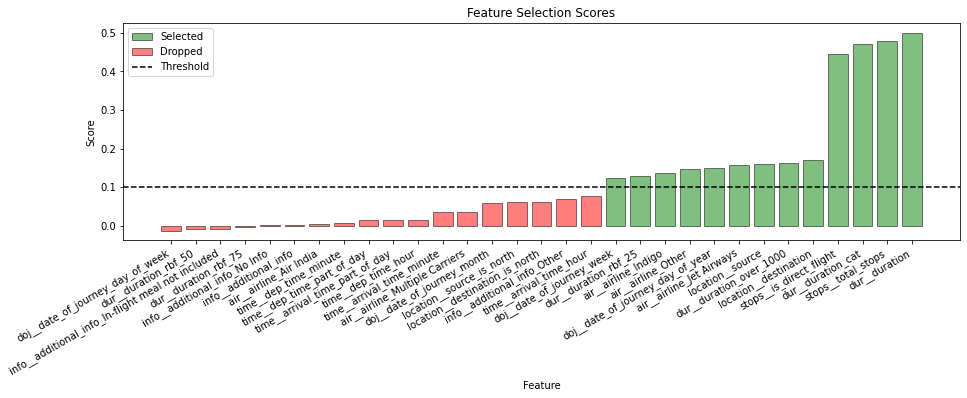

In [45]:
THRESHOLD = 0.1

selected_bar = None
dropped_bar = None
colors = ["red" if score < THRESHOLD else "green" for score in sorted_feat_imp.values()]


fig, ax = plt.subplots(figsize=(15, 4)) 

for i, (feature, score) in enumerate(sorted_feat_imp.items()):
	params = dict(
		x=i,
		height=score,
		edgecolor="black",
		alpha=0.5
	)
	
	if score < THRESHOLD:
		bar = ax.bar(
			color="red",
			**params
		)
		if not dropped_bar:
			dropped_bar = bar[0]
	else:
		bar = ax.bar(
			color="green",
			**params
		)
		if not selected_bar:
			selected_bar = bar[0]

thresh_line = ax.axhline(
	y=0.1,
	color="black",
	linestyle="--"
)

ax.set_xticks(
	ticks=range(len(sorted_feat_imp)),
	labels=list(sorted_feat_imp.keys()),
	rotation=30,
	ha="right"
)

ax.set(
	xlabel="Feature",
	ylabel="Score",
	title="Feature Selection Scores"
)

ax.legend(
	handles=[selected_bar, dropped_bar, thresh_line],
	labels=["Selected", "Dropped", "Threshold"],
	loc="upper left"
)

plt.show()

- The dataset went upto 31 columns after Feature Engineering
- The Feature Selection algorithm selected 13 features out of that